# Iterated Prisoner's Dilemma

## The problem
The Prisoner's dilemma is an example of a game that shows why two rational individuals might not cooperate, even if it appears in their best interest to do so.  
The example cites as follows:  
"Two members of a criminal gang are arrested and imprisoned. Each prisoner is in solitary confinement with no means of speaking to or exchanging messages with the other. The police admit they don't have enough evidence to convict the pair on the principal charge. They plan to sentence both to a year in prison on a lesser charge. Simultaneously, the police offer each prisoner a Faustian bargain." ([cit](https://www.worldcat.org/title/prisoners-dilemma/oclc/23383657))

Each player A and B has two actions: cooperate (C) with the other prisoner or defect (D), giving them up to the autorities. Both players decide on their action without knowing the action of the other player.

In the following matrix, the values $(A_{i,j},B_{i,j})$ refer to the payoff A and B, respectively, would get in the case A chose action $i$ and B chose action $j$, where $i,j \in \{ \text{cooperate}, \text{defect}\}$. 

$$
\begin{aligned}
& \text {Payoff matrix }\\
&\begin{array}{cccc}
\hline \hline  &  & \qquad \text{Prisoner B} \\
 &  & \text{Cooperate}  & \text{Defect} \\
\text{Prisoner A} & \text{Cooperate} & (R,R) & (S,T) \\
 & \text{Defect} & (T,S) & (P,P) \\
\hline
\end{array}
\end{aligned}
$$
This table defines a Prisoner’s Dilemma game if $T > R > P > S$ and $2R > S + T$. This way, the dilemma unfolds: For each player it is individually beneficial to defect, irrespective of the choice of his opponent. The highest mutual payoff, however, is generated when both players cooperate.

It is assumed that both prisoners understand the nature of the game, have no loyalty to each other, and will have no opportunity for retribution or reward outside the game. 

### Iterated version
If two players play the game more than once in succession and they remember previous actions of their opponent and change their strategy accordingly, the game is called Iterated Prisoner's Dilemma (IPD).  
After each game, each player observes both the previous action of their opponent and their own previous action.

## Formalisation
The prisoner's dilemma is a 2-player Matrix game, has only four states and two choices of actions. Since the reward (payoff) for a given action depends also on the actions of the other player, it is an adversarial bandits problem.  
The four states consist of all possible combinations of actions for (A's previous action, B's previous action): $(C,C), (C,D), (D,C), (D,D)$. However, this setting can be simplified in some cases presented later.

At each time $t$, the player simultaneously choose their actions. The rewards depend on both actions, and they can be written as the payoff matrix reported above.  

Considering the set of possible actions, if for any pair no individual player can benefit by changing its individual strategy, then that's a Nash equilibrium.
There has been [research](https://www.pnas.org/doi/10.1073/pnas.1206569109) showing that only one single previous state is needed, in order to define any prisoner’s dilemma strategy.

### Q-Learning 
One agent learns the value function via Q-learning, a reinforcement learning technique developed in $1989$ that iteratively updates expected cumulative discounted reward $Q$ given a state $s$, and a future action $a$ (from [Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html)):  
<img src="Qlearning.png" width="500">


The action gets chosen by default using a non-decaying $\varepsilon$-greedy policy, that is, 
$$A_t = \begin{cases} \max_a Q(A_t) \quad \text{with probability } 1- \varepsilon \\ \text{random action} \quad \text{with probability }\varepsilon \end{cases}$$

As the update rule does not depend on the current exploration but on the assumed optimal choice, Q-Learning does not require the current policy to converge towards the optimal policy, therefore doesn't *need* the decaying $\varepsilon$. Q-learning is able to generate an optimal policy even using only uniformly random actions, given sufficient iterations. However, the decay can be set as a parameter when instantiating the player.

The parameters used will be:
* The values $R = 3$, $S = 0$, $T =5$, $P=1$ for the payoff matrix
* a discount factor $\gamma = 0.95$
* a decaying learning rate $\alpha_t = \frac{1}{t+1}$
* an epsilon $\varepsilon = 0.2$. If a decay is set, the reachable minimum is set to $\varepsilon = 0.1$

The payoff matrix is
$$
\begin{aligned}
& \text {Payoff matrix }\\
&\begin{array}{cccc}
\hline \hline  &  & \qquad \text{Prisoner B} \\
 &  & \text{Cooperate}  & \text{Defect} \\
\text{Prisoner A} & \text{Cooperate} & (3,3) & (0,5) \\
 & \text{Defect} & (5,0) & (1,1) \\
\hline
\end{array}
\end{aligned}
$$

### Opponent's strategies
Over time various deterministic strategies in the IPD game emerged. The ones that will be considered here are:
* *Always cooperate*: always cooperate, indepentently of period or observed actions. If played against itself, it always receives an average reward of 3 in this setting.
* *Always defect*:  This strategy is by definition unexploitable and will always have at least the same average reward as the opposing strategy.
* *Random action*: As the name implies, this strategy plays a random action independent of period and observations. The probability to play a cooperation is here st to $0.5$.
* *Tit-for-tat*: This strategy starts with a cooperation and copies the move of the opponent in the following periods.

In the first three cases, the state space seen by the opponent could be simplified to a single default state, as these strategies do not react to their observations and are therefore always in the same situation.  
In the case of Tit-for-tat, two states would be sufficient, and they depend on whether a defection has been observed in the previous period or not.  
However, as we assume the strategy of the opponent is not known to the player, the state space cannot be simplified and all 4 possible states must be considered.

## Goal
The questions this project tries to answer are: can a Q-Learning agent learn to play:
* vs a deterministic strategy?
* vs another Q-Learning agent?

## Implementation

First, import all needed classes and functions.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from utils import Game, Meeting
from strategy import Cooperate, Defect, Random, TitforTat, QLearning

Let's define the payoff matrix, and the possible actions. We can instantiate a first game with them, and get the Nash equilibrium.

In [2]:
# define payoff matrix
payoff =[[(3,3),(0,5)],[(5,0),(1,1)]]

# initiate game with two possible actions: cooperate or defect
# numeric action codes: [0,1]
actions = [0,1] 
g = Game(payoff, actions)

# returns a list of Nash equilibrium indexes
g.getNash() 

[(1, 1)]

As expected, the Nash equilibrium is to defect.

Let's see how the strategies play out. Remember that 0 = Cooperate, 1 = Defect.

In [3]:
# test action classes
for strategy in [Cooperate(), Defect(), Random()]: 
    s1 = strategy
    print(s1.name,end=" ")
    for i in range (0,20):
        print(s1.get_action(i), end=' ')
    print('\n')

cooperate 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

defect 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

random 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 



To test Tit-for-Tat, we need an opponent, so we create a meeting. The player starts by cooperating, to then copy the opponent's previous action.  
```pretty_print()``` reports the first (max 50) actions for each player and their scores. The score is the sum of the scores obtained on each game, according to the payoff matrix. The higher the better.

In [4]:
m = Meeting(g, TitforTat(), Random(), 20)
m.run()
m.pretty_print()

TitforTat	0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 ... 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 = 34
random	0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 ... 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 = 39


We can also display the counter for how many times each player decided to cooperate.

In [5]:
s1 = TitforTat()
s2 = Defect()
m = Meeting(g, s1, s2, 100)
m.run()
m.pretty_print()

print()
print("Number of cooperations : " )
print (m.s1.name + "\t" + str(m.num_cooperation_s1))
print (m.s2.name + "\t" + str(m.num_cooperation_s2))

TitforTat	0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 = 99
defect	1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 = 104

Number of cooperations : 
TitforTat	1
defect	0


### All vs all

Let's play every strategy against every opponent, counting the average reward per game of Player 1 against Player 2.  
Again, each time the cell is ran the results can vary due to randomness, although the decision to run the same meeting multiple times to infer the results was made to reduce the effect.

For the Q-learner, a few different combinations of parameters are tried.

In [6]:
payoff =[[(3,3),(0,5)],[(5,0),(1,1)]]
actions = [0,1] 
g = Game(payoff, actions)

strategies = [Cooperate(), Defect(), Random(), TitforTat(), QLearning(epsilon = 0.2), QLearning(epsilon = 0.5), QLearning(epsilon=0.5, decay = 0.999)]
avg_reward_table = []
wins_table = []
runs = 100
games = 10000

for player1 in strategies:
    avg_reward = []
    wins_percent = []
    for player2 in strategies:
        tot_reward = 0
        tot_wins = 0
        for i in range(runs):
            s1 = player1
            s2 = player2
            m = Meeting(g, s1, s2, games)
            m.run()
            tot_reward += m.s1_score
            if m.s1_score > m.s2_score:
                tot_wins += 1
        avg_reward.append(tot_reward/(runs*games))
        wins_percent.append(tot_wins/runs)
    avg_reward_table.append(avg_reward)
    wins_table.append(wins_percent)

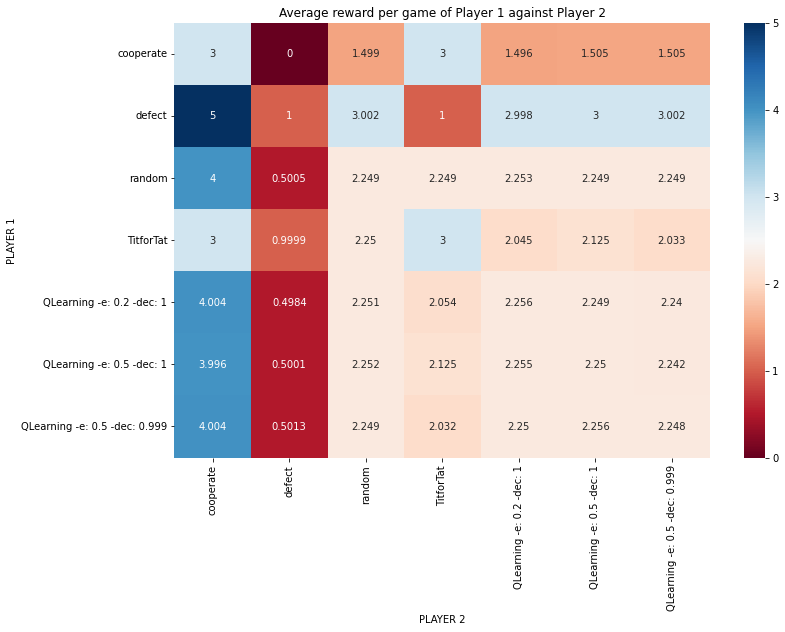

In [7]:
df = pd.DataFrame(avg_reward_table, index = [s.name for s in strategies], columns = [s.name for s in strategies])

plt.figure(figsize = (12,8))
s = sn.heatmap(df, annot=True, cmap = 'RdBu', fmt = '.4g')
s.set(xlabel='PLAYER 2', ylabel='PLAYER 1', title=f'Average reward per game of Player 1 against Player 2');

Each player's goal is to maximise their own reward.  
As we can see from the table, always cooperating is the worst strategy, as it leads to the worst average results in most cases and, even in its best cases, the rewards are  only slightly above average.
Second worse to Cooperate is Tit-for-Tat, which follows its same trend but with less extreme below-average results.  
Like the Nash equilibrium suggested, the best bet is to always defect. That way, whichever action Player 2 chooses, Player 1's payoff will always be the highest possible. The obtained reward is, in $66\%$ of cases, above average, and there is a possibility to obtain the highest payoff possible, which other strategies don't have.  

Let's look at the Q-learners' results. They all perform very similarly in most cases, except when facing Tit-for-Tat, in which case a higher exploration is slightly preferred.

To help answer the original questions, let's plot the percentage of wins, too.

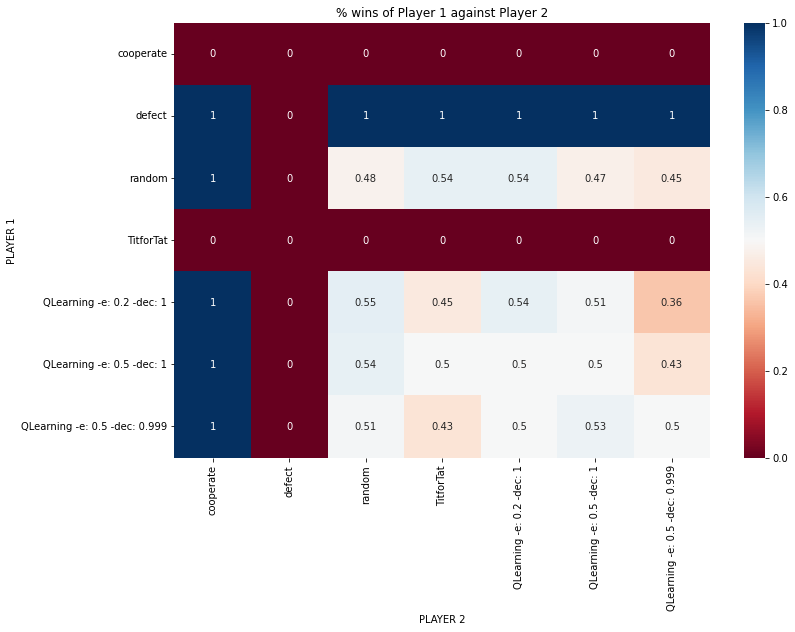

In [8]:
df = pd.DataFrame(wins_table, index = [s.name for s in strategies], columns = [s.name for s in strategies])

plt.figure(figsize = (12,8))
s = sn.heatmap(df, annot=True, cmap = 'RdBu', fmt = '.4g')
s.set(xlabel='PLAYER 2', ylabel='PLAYER 1', title=f'% wins of Player 1 against Player 2');

However, a higher starting exploration percentage and the introduction of decay produce more wins. This doesn't affect the performance evaluation of the players, as the aim is highest reward, but it is still interesting to see.

## Answers

Let's see if the Q-learning agent has learnt some strategies against the different opponents by exploring the resulting Q tables and history of actions. It's parameters will be set to the ones that got the highest average reward in the previous table.

### Can a Q-learning agent learn to play against a deterministic strategy?

In [9]:
# how to read the Q table:
# first as states:
# [[I cooperate],         in each block:  
#                         [[they cooperate],                   in each row, for action:
#  [I defect   ]]         [they defect   ]]                    [next is cooperate, next is defect]

In [10]:
s1 = QLearning()
s2 = Cooperate()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()

QLearning -e: 0.2 -dec: 1	1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 ... 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 = 200536
cooperate	0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 = 74196


array([[[18.78393106,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        , 22.51756818],
        [ 0.        ,  0.        ]]])

The RL agent gets a heavy win, as expected.  
The Q table is updated only for instances when the opponent cooperates, as the agent has no occasions to explore the other states. The learnt strategy is basically to repeat my last action, so to cooperate if I cooperated earlier, and to defect otherwise. This is backed by the printed sequence: the agent repeats the same action for many games consecutively, until a randomized action doesn't kick in and change the state.  
However, the Q-learner should have learnt to always betray the opponent, in order to maximise its own win. This fails to happen.

In [11]:
s1 = QLearning()
s2 = Defect()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
# m.s1.print_qtable()

QLearning -e: 0.2 -dec: 1	1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 = 25217
defect	1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 = 149132


The Q-learner loses drastically to the defecting opponent, as predicted from the table above. Again, the states that include a cooperation from the opponent are not explored, for clear reasons.  
In this case, the agent only option was to learn to always defect as well, and aim for a tie. This, again, fails to happen.

In [12]:
s1 = QLearning(epsilon = 0.5, decay = 0.999)
s2 = Random()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()

QLearning -e: 0.5 -dec: 0.999	1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 ... 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 = 113680
random	0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 ... 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 = 110345


array([[[6.32670874, 0.        ],
        [6.07749605, 0.        ]],

       [[0.        , 7.99085444],
        [0.        , 7.41779522]]])

In [13]:
s1 = QLearning(epsilon = 0.5)
s2 = TitforTat()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()

QLearning -e: 0.5 -dec: 1	0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 ... 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 = 106053
TitforTat	0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 ... 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 = 106053


array([[[10.16131581,  0.        ],
        [ 6.68928793,  0.        ]],

       [[ 0.        ,  2.27988102],
        [ 0.        ,  3.83947348]]])

With these past two strategies, ```Random()``` and ```TitforTat()```, the player learns to, whatever the opponent does, repeat their own last action. Again, this changes only if a randomised action comes into play. 

As Tit-for-Tat is a strategy which is not aimed at winning but at a tie, the RL agent always ends up with a tie or with a win by a very small margin.  
Instead, with the opponent playing a random action at each game, the results have more variance, with the RL agent balancing more or less half wins and half losses, but all with a relatively small margin as far as rewards. 

As anticipated by the table above, the RL agent wins a higher reward when playing against a random opponent, rather than Tit-for-Tat. The best case happens when the opponent cooperates, and the worst when it defects.

In conclusion, generally a Q-learner cannot be said to be a *good* player in the Prisoner's dilemma if the opponent plays a deterministic strategy, as in most cases gets an average reward, comparable to the one it would get playing randomly.

### Can a Q-learning agent learn to play against another Q-learning agent?

Using the default values, as there ins't much variation in performance as far as average reward.

In [14]:
s1 = QLearning()
s2 = QLearning()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()
m.s1.print_qtable()


QLearning -e: 0.2 -dec: 1	0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 ... 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 = 112681
QLearning -e: 0.2 -dec: 1	0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 ... 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 = 110831


array([[[ 9.23893577,  0.        ],
        [ 2.6437609 ,  0.        ]],

       [[ 0.        , 12.43299911],
        [ 0.        ,  3.71888554]]])

In [15]:
m.s2.print_qtable()

array([[[7.5879374 , 0.        ],
        [2.54844525, 0.        ]],

       [[0.        , 8.55637876],
        [0.        , 3.07214972]]])

The two Q-learners learn a similar Q table, but fail to learn to cooperate to maximise both the rewards.  
In fact, their rewards are similar to what they would have gotten playing against a Random opponent, or even to what to two random opponents would have gotten playing agaist each other:

In [16]:
s1 = Random()
s2 = Random()
m = Meeting(g, s1, s2, 50000)
m.run()
m.pretty_print()

random	1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 ... 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 = 112698
random	0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 ... 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 = 111653


In closing, a Q-learning agent can be fully compared to an agent that plays a random action. This cannot be considered a good result, as the same outcome can be obtained with much less complexity and memory.